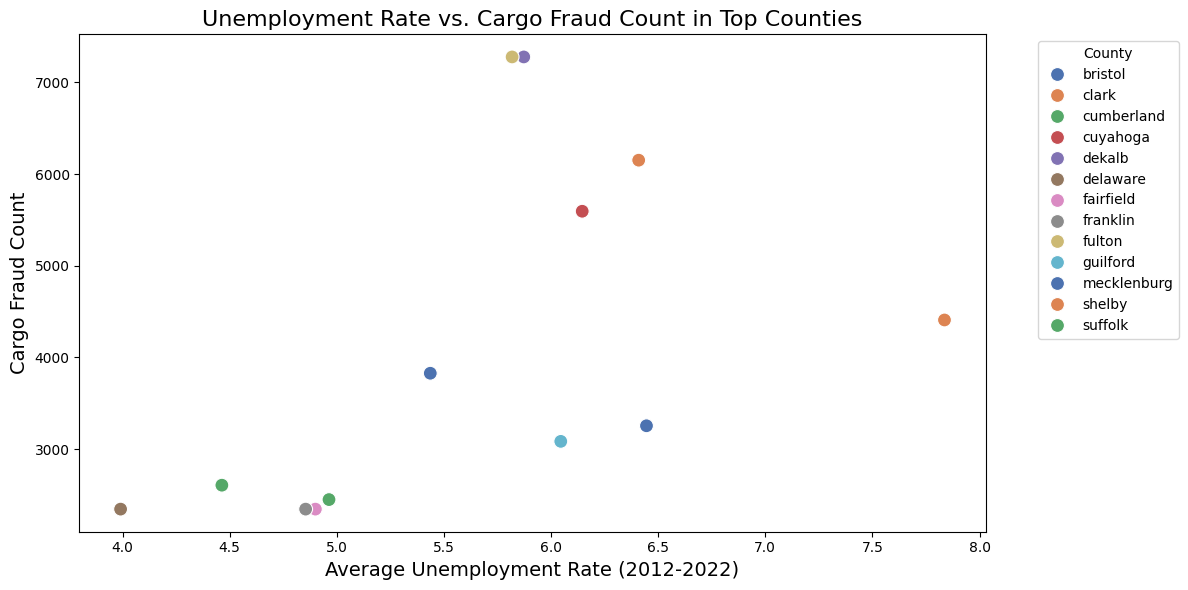

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz
from thefuzz import process

# Install the required libraries if not already installed
# !pip install pandas matplotlib seaborn thefuzz python-Levenshtein

# Step 1: Load and Prepare the Cargo Fraud Data
# Load the cargo fraud data
data_cargo_fraud = pd.read_csv('cargo_fraud_only.csv')

# Ensure 'Year' column exists
if 'Year' not in data_cargo_fraud.columns:
    if 'data_year' in data_cargo_fraud.columns:
        data_cargo_fraud['Year'] = data_cargo_fraud['data_year'].astype(int)
    else:
        data_cargo_fraud['date_recovered'] = pd.to_datetime(data_cargo_fraud['date_recovered'], errors='coerce')
        data_cargo_fraud['Year'] = data_cargo_fraud['date_recovered'].dt.year
        data_cargo_fraud = data_cargo_fraud.dropna(subset=['Year'])
        data_cargo_fraud['Year'] = data_cargo_fraud['Year'].astype(int)

# Filter data for years 2012 to 2022 using 'Year' column
data_cargo_fraud = data_cargo_fraud[(data_cargo_fraud['Year'] >= 2012) & (data_cargo_fraud['Year'] <= 2022)]

# Standardize 'state_name' and 'county_name' columns without overwriting existing columns
data_cargo_fraud['state_clean'] = data_cargo_fraud['state_name'].str.lower().str.strip()
data_cargo_fraud['county_clean'] = data_cargo_fraud['county_name'].str.lower().str.strip()

# Aggregate fraud counts by county
county_stats = data_cargo_fraud.groupby(['state_clean', 'county_clean']).size().reset_index(name='Fraud_Count')

# Step 2: Prepare the Top Counties DataFrame
# Sort counties by fraud count in descending order
county_stats_sorted = county_stats.sort_values(by='Fraud_Count', ascending=False)
top_counties = county_stats_sorted.head(10).copy()

# Standardize 'county_clean' and 'state_clean' in 'top_counties'
top_counties['county_clean'] = top_counties['county_clean'].str.lower().str.strip()
top_counties['state_clean'] = top_counties['state_clean'].str.lower().str.strip()

# Step 3: Split Combined County Names in 'top_counties'
# Split 'county_clean' by commas and explode the DataFrame
top_counties['county_clean_list'] = top_counties['county_clean'].str.split(r',\s*')
top_counties_exploded = top_counties.explode('county_clean_list')
top_counties_exploded['county_clean'] = top_counties_exploded['county_clean_list'].str.strip()
top_counties_exploded = top_counties_exploded.drop(columns=['county_clean_list'])

# Step 4: Load and Prepare the Unemployment Data
# Load unemployment data
unemployment_data = pd.read_csv('Unemployment.csv')

# Extract county name and state abbreviation from 'Area_Name'
unemployment_data['county_clean'] = unemployment_data['Area_Name'].str.extract(r'^(.*) County,')[0].str.lower().str.strip()
unemployment_data['state_abbr'] = unemployment_data['Area_Name'].str.extract(r', (\w\w)$')[0]

# Create state abbreviation to name mapping
state_abbrev_to_name = {
    'al': 'alabama',
    'ak': 'alaska',
    'az': 'arizona',
    'ar': 'arkansas',
    'ca': 'california',
    'co': 'colorado',
    'ct': 'connecticut',
    'de': 'delaware',
    'fl': 'florida',
    'ga': 'georgia',
    'hi': 'hawaii',
    'id': 'idaho',
    'il': 'illinois',
    'in': 'indiana',
    'ia': 'iowa',
    'ks': 'kansas',
    'ky': 'kentucky',
    'la': 'louisiana',
    'me': 'maine',
    'md': 'maryland',
    'ma': 'massachusetts',
    'mi': 'michigan',
    'mn': 'minnesota',
    'ms': 'mississippi',
    'mo': 'missouri',
    'mt': 'montana',
    'ne': 'nebraska',
    'nv': 'nevada',
    'nh': 'new hampshire',
    'nj': 'new jersey',
    'nm': 'new mexico',
    'ny': 'new york',
    'nc': 'north carolina',
    'nd': 'north dakota',
    'oh': 'ohio',
    'ok': 'oklahoma',
    'or': 'oregon',
    'pa': 'pennsylvania',
    'ri': 'rhode island',
    'sc': 'south carolina',
    'sd': 'south dakota',
    'tn': 'tennessee',
    'tx': 'texas',
    'ut': 'utah',
    'vt': 'vermont',
    'va': 'virginia',
    'wa': 'washington',
    'wv': 'west virginia',
    'wi': 'wisconsin',
    'wy': 'wyoming',
    'dc': 'district of columbia',
}

# Convert state abbreviations to full state names
unemployment_data['state_clean'] = unemployment_data['state_abbr'].str.lower().map(state_abbrev_to_name)

# Handle special cases where state abbreviation might be missing
unemployment_data['state_clean'] = unemployment_data['state_clean'].fillna(unemployment_data['State'].str.lower())

# Filter unemployment data for 2012 to 2022
unemployment_cols = [col for col in unemployment_data.columns if 'Unemployment_rate_' in col and col[-4:].isdigit() and 2012 <= int(col[-4:]) <= 2022]

# **FIX APPLIED HERE**: Create a copy of the DataFrame slice
unemployment_rates = unemployment_data[['state_clean', 'county_clean'] + unemployment_cols].copy()

# Convert unemployment rates to numeric and handle errors
for col in unemployment_cols:
    # **FIX APPLIED HERE**: Use .loc[] to avoid SettingWithCopyWarning
    unemployment_rates.loc[:, col] = pd.to_numeric(unemployment_rates[col], errors='coerce')

# Calculate average unemployment rate from 2012 to 2022
unemployment_rates['Avg_Unemployment_Rate'] = unemployment_rates[unemployment_cols].mean(axis=1)

# Step 5: Merge Cargo Fraud Data with Unemployment Data
# Merge with unemployment rates
merged_data = top_counties_exploded.merge(
    unemployment_rates,
    on=['state_clean', 'county_clean'],
    how='left'
)

# Identify rows with NaN in 'Avg_Unemployment_Rate'
missing_unemployment = merged_data[merged_data['Avg_Unemployment_Rate'].isna()]

# Step 6: Use Fuzzy Matching for Unmatched Counties (Optional)
# For unmatched counties, attempt to match using fuzzy matching
def match_county(county_name, county_list):
    match = process.extractOne(county_name, county_list, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= 90:  # Threshold of 90% similarity
        return match[0]
    else:
        return None

# Get list of unique counties in unemployment data for each state
state_county_dict = unemployment_rates.groupby('state_clean')['county_clean'].apply(list).to_dict()

# Attempt to match missing counties
for idx, row in missing_unemployment.iterrows():
    state = row['state_clean']
    county = row['county_clean']
    county_list = state_county_dict.get(state, [])
    matched_county = match_county(county, county_list)
    if matched_county:
        merged_data.loc[idx, 'county_clean'] = matched_county
        merged_data.loc[idx, 'Avg_Unemployment_Rate'] = unemployment_rates[
            (unemployment_rates['state_clean'] == state) &
            (unemployment_rates['county_clean'] == matched_county)
        ]['Avg_Unemployment_Rate'].values[0]

# Remove any remaining rows with NaN in 'Avg_Unemployment_Rate'
merged_data = merged_data.dropna(subset=['Avg_Unemployment_Rate'])

# Step 7: Aggregate Data if Necessary
# After merging and matching, aggregate the data
merged_data = merged_data.groupby(['county_clean', 'state_clean']).agg({
    'Fraud_Count': 'sum',
    'Avg_Unemployment_Rate': 'mean'
}).reset_index()

# Step 8: Plot Unemployment Rate vs. Fraud Count
# Plot Unemployment Rate vs. Fraud Count
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Avg_Unemployment_Rate',
    y='Fraud_Count',
    data=merged_data,
    hue='county_clean',
    palette='deep',
    s=100
)

# Customize the plot
plt.xlabel('Average Unemployment Rate (2012-2022)', fontsize=14)
plt.ylabel('Cargo Fraud Count', fontsize=14)
plt.title('Unemployment Rate vs. Cargo Fraud Count in Top Counties', fontsize=16)
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


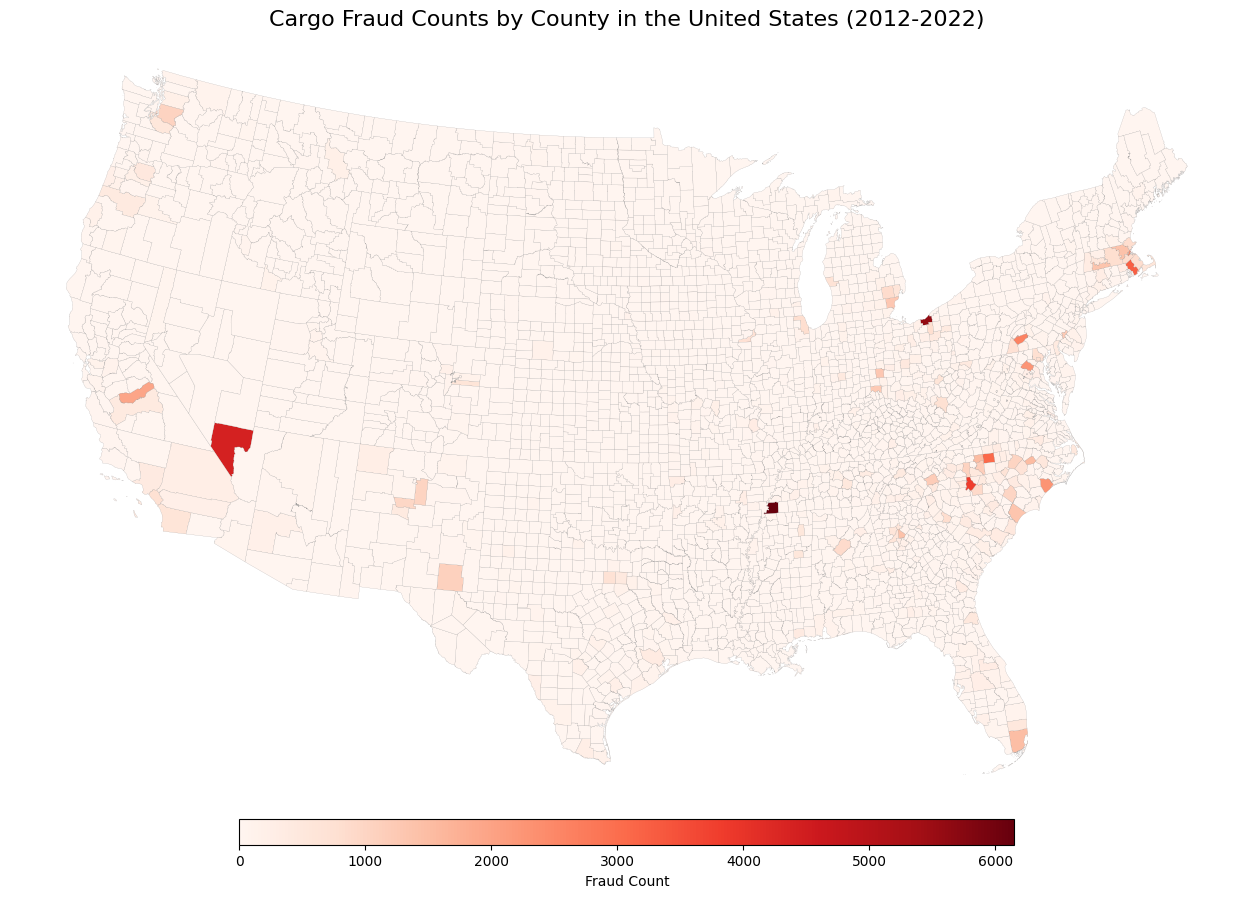

In [8]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Load the cargo fraud data
data_cargo_fraud = pd.read_csv('cargo_fraud_only.csv')

# Step 2: Ensure 'Year' column exists
if 'Year' not in data_cargo_fraud.columns:
    if 'data_year' in data_cargo_fraud.columns:
        data_cargo_fraud['Year'] = data_cargo_fraud['data_year'].astype(int)
    else:
        data_cargo_fraud['date_recovered'] = pd.to_datetime(data_cargo_fraud['date_recovered'], errors='coerce')
        data_cargo_fraud['Year'] = data_cargo_fraud['date_recovered'].dt.year
        data_cargo_fraud = data_cargo_fraud.dropna(subset=['Year'])
        data_cargo_fraud['Year'] = data_cargo_fraud['Year'].astype(int)

# Step 3: Filter data for years 2012 to 2022
data_cargo_fraud = data_cargo_fraud[(data_cargo_fraud['Year'] >= 2012) & (data_cargo_fraud['Year'] <= 2022)]

# Step 4: Standardize 'county_name' and 'state_name' columns
data_cargo_fraud['county_clean'] = data_cargo_fraud['county_name'].str.lower().str.strip()
data_cargo_fraud['state_clean'] = data_cargo_fraud['state_name'].str.lower().str.strip()

# Step 5: Aggregate fraud counts by 'state_clean' and 'county_clean'
county_stats = data_cargo_fraud.groupby(['state_clean', 'county_clean']).size().reset_index(name='Fraud_Count')

# Step 6: Load US counties shapefile directly from the Census Bureau's website
counties_shp_url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip'
counties = gpd.read_file(counties_shp_url)

# Step 7: Load US states shapefile to map state FIPS codes to state names
states_shp_url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'
states = gpd.read_file(states_shp_url)
state_fips_to_name = states.set_index('STATEFP')['NAME'].to_dict()

# Step 8: Prepare the counties GeoDataFrame
counties['county_clean'] = counties['NAME'].str.lower().str.strip()
counties['state_clean'] = counties['STATEFP'].map(state_fips_to_name).str.lower().str.strip()

# Step 9: Merge counties GeoDataFrame with county_stats DataFrame
merged_gdf = counties.merge(county_stats, on=['state_clean', 'county_clean'], how='left')

# Step 10: Replace NaN values in 'Fraud_Count' with 0
merged_gdf['Fraud_Count'] = merged_gdf['Fraud_Count'].fillna(0)

# Step 11: Exclude Alaska, Hawaii, and territories
excluded_state_fips = ['02', '15', '60', '66', '69', '72', '78']  # FIPS codes for AK, HI, and territories
merged_gdf = merged_gdf[~merged_gdf['STATEFP'].isin(excluded_state_fips)].reset_index(drop=True)

# Step 12: Reproject geometries (Optional)
# Using Albers Equal Area projection for the US
merged_gdf = merged_gdf.to_crs(epsg=5070)

# Step 13: Plotting the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Plot counties colored by 'Fraud_Count'
merged_gdf.plot(
    column='Fraud_Count',
    ax=ax,
    cmap='Reds',
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    legend_kwds={
        'label': "Fraud Count",
        'orientation': "horizontal",
        'shrink': 0.5,
        'pad': 0.01,
        'aspect': 30
    }
)

# Remove axis for clarity
ax.set_axis_off()

# Add title
ax.set_title('Cargo Fraud Counts by County in the United States (2012-2022)', fontsize=16)

# Show the plot
plt.show()
